# Accessing Truth Catalog Information

**Owner:** Scott Daniel (@danielsf)

**Last Run:** 2018-10-17 (by @yymao)

**Learning Objectives:** We have implemented a catalog containing truth information for DC2 Run 1.1 and 1.2.  This notebook will introduce the contents of that notebook as well as how to query them.

**Note:** Currently, the truth catalog only contains static sources.  We still need to design a way to efficiently deliver light curves for all of the transient and variable sources in DC2.  Galaxies with time-varying AGN and variable stars in this catalog report a magntiude which is the baseline magnitude on top of which the variability model is applied.

To run this notebook, follow the instructions to setup Jupyter-dev at NERSC: https://confluence.slac.stanford.edu/x/1_ubDQ

In [1]:
# import packages and methods that will be used in this notebook

import healpy
import numpy as np
import GCRCatalogs
from astropy.coordinates import SkyCoord
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

First, load the catalog.

In [2]:
truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')

You can list the quantities contained in the catalog using the same API as any other GCR-based catalog.

In [3]:
truth_catalog.list_all_quantities(include_native=True)

['agn',
 'mag_true_z',
 'ra',
 'u',
 'mag_true_i',
 'object_id',
 'redshift',
 'mag_true_u',
 'mag_true_g',
 'z',
 'g',
 'r',
 'y',
 'mag_true_y',
 'sprinkled',
 'dec',
 'i',
 'mag_true_r',
 'healpix_2048',
 'star']

The `get_quantity_info` method will give you access to descriptions of all of the native quantities in the catalog.  Note that the quantities `ugrizy` map directly to `mag_true_[ugrizy]'.

In [4]:
for qty in ['object_id', 'ra', 'dec', 'redshift', 'healpix_2048',
            'agn', 'star', 'sprinkled',
            'u', 'g', 'r', 'i', 'z', 'y']:
    info_dict = truth_catalog.get_quantity_info(qty)
    print(qty,info_dict)

object_id {'description': 'an int uniquely identifying objects (can collide between stars, galaxies, and sprinkled objects)'}
ra {'description': 'in degrees'}
dec {'description': 'in degrees'}
redshift {'description': 'cosmological only'}
healpix_2048 {'description': 'healpixel containing the object (nside=2048; nested)'}
agn {'description': 'an int; ==1 if galaxy has an AGN; ==0 if not'}
star {'description': 'an int; ==1 if a star; ==0 if not'}
sprinkled {'description': 'an int; ==1 if object added by the sprinkler; ==0 if not'}
u {'description': 'observed lsst u magnitude; no dust extinction at all'}
g {'description': 'observed lsst g magnitude; no dust extinction at all'}
r {'description': 'observed lsst r magnitude; no dust extinction at all'}
i {'description': 'observed lsst i magnitude; no dust extinction at all'}
z {'description': 'observed lsst z magnitude; no dust extinction at all'}
y {'description': 'observed lsst y magnitude; no dust extinction at all'}


In the cells below, we will query the catalog for all of the bright stars and galaxies in a 0.2 degree disc centered on `RA=54.6`, `Dec=-28.0`.

In the next cell, will define some methods (`filter_on_healpix` and `filter_on_dist`) needed to make that selection.  These methods will be passed into the catalog's `get_quantities` method with the `filters` kwarg.  The methods should accept numpy arrays and return a numpy array of booleans indicating whether or not each object in the input arrays passed the test.

We will use `healpy`'s `query_disc` method to find which healpixels overlap our region of interest.

In [5]:
center_ra = 54.6
center_dec = -28.0
radius = 0.2

center_ra_rad = np.radians(center_ra)
center_dec_rad = np.radians(center_dec)

center_vec = np.array([np.cos(center_dec_rad)*np.cos(center_ra_rad),
                       np.cos(center_dec_rad)*np.sin(center_ra_rad),
                       np.sin(center_dec_rad)])

list_of_healpix = healpy.query_disc(2048, center_vec, np.radians(radius), nest=True, inclusive=True)

def filter_on_healpix(hp):
    return np.array([hh in list_of_healpix for hh in hp])

def angularSeparation(ra, dec, center_ra, center_dec):
    return SkyCoord(ra, dec, unit='deg').separation(SkyCoord(center_ra, center_dec, unit='deg')).deg

def filter_on_dist(ra, dec):
    return angularSeparation(ra, dec, center_ra, center_dec) < radius

Now we will query the catalog or all stars (`star==1`) in the region of interest with magnitude `r<17.0`.  This query functions like any other GRC-based catalog query with one exception.  The truth catalog is ultimately stored as a sqlite database.  This means that all `native_filters` (filters applied directly to the catalog's native quantities), should be phrased as strings which could be inserted into an SQL `WHERE` clause.  Because the `native_filters` are applied when the quantities loaded into memory (as opposed to `filters`, which are applied after the quantities have been loaded), we want these to be as restrictive as possible so as to limit the memory consumption of the loaded catalog.  The sqlite databases are indexed on `star`, `agn`, `sprinkled`, `healpix_2048` and `object_id`.

**Note:** We are aware that `nside==2048` healpixels may be too fine a resolution to helpfully limit the catalog query.  We are open to the idea of using a coarser resolution in future truth catalogs.

After the coarse spatial limits applied by the `native_filter` on `healpix_2048`, we use the `filter_on_healpix` and `filter_on_dist` methods to actually get sources in our region of interest.

In [6]:
bright_stars = truth_catalog.get_quantities(['ra', 'dec', 'mag_true_r'],
                                            native_filters=['star==1',
                                                            'r<17.0',
                                                            'healpix_2048<=%d' % list_of_healpix.max(),
                                                            'healpix_2048>=%d' % list_of_healpix.min()],
                                            filters=[(filter_on_healpix, 'healpix_2048'),
                                                     (filter_on_dist, 'ra', 'dec')])

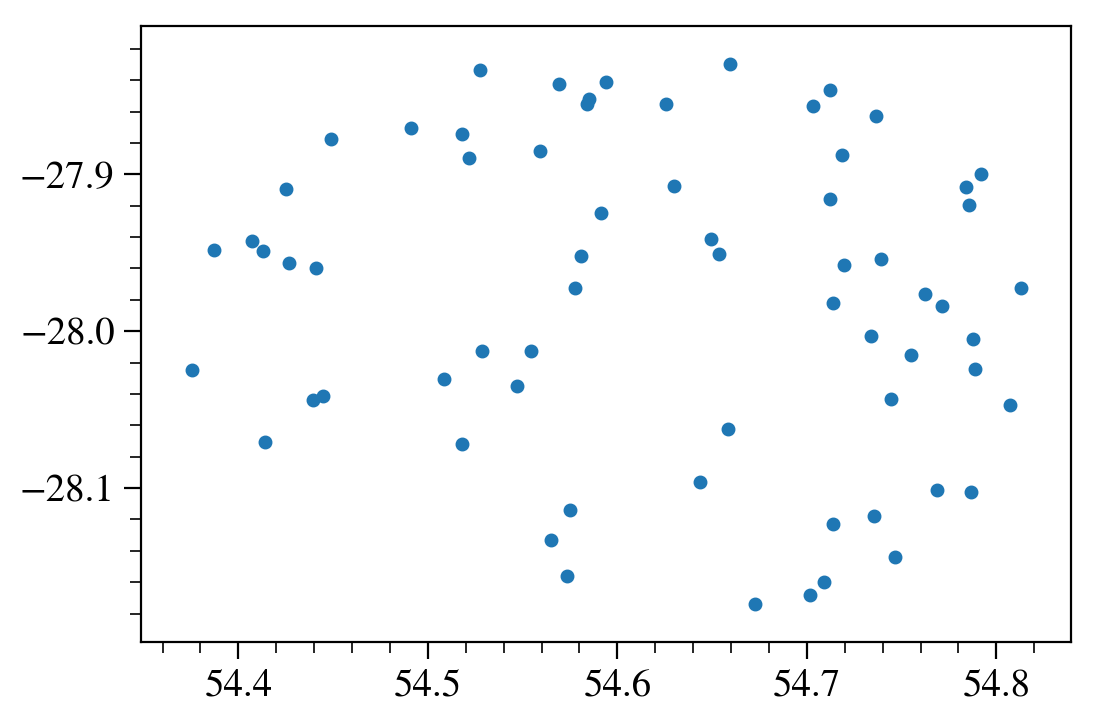

In [7]:
plt.scatter(bright_stars['ra'], bright_stars['dec'])

Now we will performa similar spatial query for galaxies (`star==0`) which were not added by the sprinkler (`sprinkled==1`) with magnitudes `r<21`.

***Note:** "the sprinkler" is a piece of code used to add an extra population of AGN and supernovae into the Utral Deep Drilling Field of DC2.  Objects added by the sprinkler will have no counterpart in the underlying protoDC2 extragalactic catalog, which is why we have added a `sprinkled` flag to the catalog.

In [8]:
bright_unsprinkled_galaxies = truth_catalog.get_quantities(['ra', 'dec', 'mag_true_r'],
                                                           native_filters=['star==0', 'sprinkled==0',
                                                                           'r<21.0',
                                                                           'healpix_2048<=%d' % list_of_healpix.max(),
                                                                           'healpix_2048>=%d' % list_of_healpix.min()],
                                                           filters=[(filter_on_healpix, 'healpix_2048'),
                                                                    (filter_on_dist, 'ra', 'dec')])

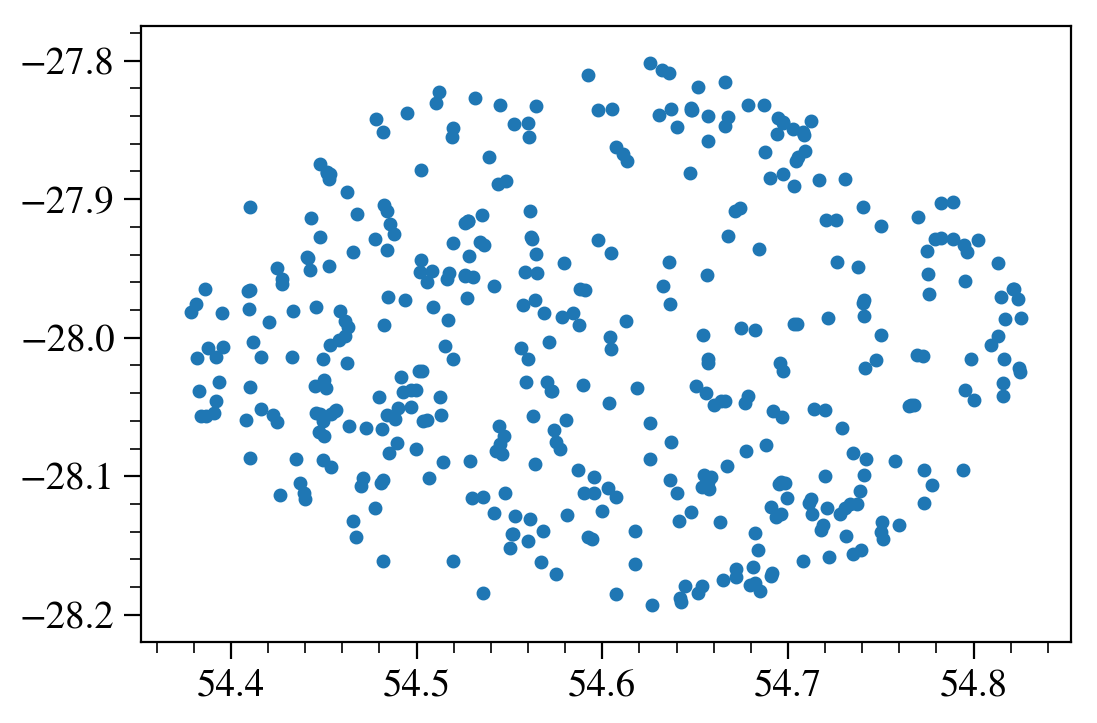

In [9]:
plt.scatter(bright_unsprinkled_galaxies['ra'], bright_unsprinkled_galaxies['dec'])

In [10]:
print(bright_unsprinkled_galaxies['mag_true_r'].min())

15.333934208424253
